
### The first part of this notebook will try to use the tabular learner from Fastai, some minor feature engineering is done, but there is still a lot of work to be done to achieve higher accuracy!  Final results are at the end of the notebook!


In [ ]:
import pandas as pd
import fastai
from fastai.tabular import *
import os
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler


In [2]:
os.listdir('data')

['application_train.csv',
 'credit_card_balance.csv',
 'bureau.csv',
 'application_test.csv',
 'POS_CASH_balance.csv',
 'installments_payments.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'HomeCredit_columns_description.csv',
 'sample_submission.csv']

In [3]:
buro_bal = pd.read_csv('data/bureau_balance.csv')
buro_bal.shape

(27299925, 3)

In [4]:
#transform to dummies
buro_bal = pd.concat([buro_bal,pd.get_dummies(buro_bal.STATUS,prefix = 'buro_bal_status')] 
                     ,axis = 1).drop('STATUS', axis=1)

In [5]:
#counting buros
buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

In [6]:
#averaging buro bal
avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

In [7]:
avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
del buro_bal
gc.collect()

27

In [8]:
buro = pd.read_csv('data/bureau.csv')

In [9]:
buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')


In [10]:
buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)


In [11]:
buro_full

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,ty__Interbank credit,ty__Loan for business development,ty__Loan for purchase of shares (margin lending),ty__Loan for the purchase of equipment,ty__Loan for working capital replenishment,ty__Microloan,ty__Mobile operator loan,ty__Mortgage,ty__Real estate loan,ty__Unknown type of loan
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,...,0,0,0,0,0,1,0,0,0,0
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,...,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
gc.collect()

20

In [13]:
#'Merge with buro avg'
buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

In [14]:
nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])


In [15]:
avg_buro = buro_full.groupby('SK_ID_CURR').mean()

In [16]:
avg_buro.head()

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,avg_buro_MONTHS_BALANCE,avg_buro_buro_bal_status_0,avg_buro_buro_bal_status_1,avg_buro_buro_bal_status_2,avg_buro_buro_bal_status_3,avg_buro_buro_bal_status_4,avg_buro_buro_bal_status_5,avg_buro_buro_bal_status_C,avg_buro_buro_bal_status_X,avg_buro_buro_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7.0,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,...,-11.785714,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590,24.571429
100002,8.0,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,...,-21.875000,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,13.750000
100003,4.0,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,2.0,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,3.0,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,...,-3.000000,0.735043,0.000000,0.0,0.0,0.0,0.0,0.128205,0.136752,7.000000


In [17]:
del buro, buro_full
gc.collect()

20

In [18]:
prev = pd.read_csv('data/previous_application.csv')
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]

In [20]:
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)

prev = pd.concat([prev, prev_dum], axis=1)


In [21]:
del prev_dum
gc.collect()



20

In [22]:
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0,0,0,0,0,0,1,0,0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,1,0,0,0,0,0,0,0,0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,0,0,0,0,0,0,0,0,0,0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,0,1,0,0,0,0,0,0,0,0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Counting number of Prevs
nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])

In [24]:
avg_prev = prev.groupby('SK_ID_CURR').mean()


In [25]:
avg_prev.head()

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
100002,1.0,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
100003,3.0,56553.990,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
100004,1.0,5357.250,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212008,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
100005,2.0,4813.200,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108964,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0


In [26]:
del prev
gc.collect()

100

In [27]:
pos = pd.read_csv('data/POS_CASH_balance.csv')

In [28]:
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)

In [29]:
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

In [30]:
avg_pos = pos.groupby('SK_ID_CURR').mean()

In [31]:
del pos, nb_prevs
gc.collect()

100

In [32]:
cc_bal = pd.read_csv('data/credit_card_balance.csv')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)


In [33]:
nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
del cc_bal, nb_prevs
gc.collect()


40

In [34]:
inst = pd.read_csv('data/installments_payments.csv')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])


In [35]:
avg_inst = inst.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]


In [47]:
data = pd.read_csv('data/application_train.csv')
test = pd.read_csv('data/application_test.csv')

In [48]:
data.shape


(307511, 122)

In [49]:
test.shape

(48744, 121)

In [50]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

    
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')


In [51]:

feats = [f for f in data.columns if f not in ['SK_ID_CURR']]
print(len(feats))
print(len(categorical_feats))


380
16


In [77]:
data.shape


(307511, 381)

In [42]:


#data.to_csv('data.csv')
#test.to_csv('test.csv')

#data = pd.read_csv('data/previous_application.csv')
#test =pd.read_csv('data/application_test.csv')


In [53]:
dep_var = 'TARGET'

In [54]:
cat_names = categorical_feats
cont_names = [f for f in feats if f not in categorical_feats]
cont_names.remove('TARGET')

In [55]:
procs = [FillMissing, Categorify, Normalize]
X_test= TabularList.from_df(test.copy(), cat_names=cat_names, cont_names=cont_names)

In [56]:
X_train = (TabularList.from_df(data, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct=0.2)
                           .label_from_df(cols=dep_var)
                           .add_test(X_test)
                           .databunch())

In [57]:
X_train.show_batch()


NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,AMT_ANNUITY_x_na,AMT_GOODS_PRICE_x_na,OWN_CAR_AGE_na,CNT_FAM_MEMBERS_na,EXT_SOURCE_1_na,EXT_SOURCE_2_na,EXT_SOURCE_3_na,APARTMENTS_AVG_na,BASEMENTAREA_AVG_na,YEARS_BEGINEXPLUATATION_AVG_na,YEARS_BUILD_AVG_na,COMMONAREA_AVG_na,ELEVATORS_AVG_na,ENTRANCES_AVG_na,FLOORSMAX_AVG_na,FLOORSMIN_AVG_na,LANDAREA_AVG_na,LIVINGAPARTMENTS_AVG_na,LIVINGAREA_AVG_na,NONLIVINGAPARTMENTS_AVG_na,NONLIVINGAREA_AVG_na,APARTMENTS_MODE_na,BASEMENTAREA_MODE_na,YEARS_BEGINEXPLUATATION_MODE_na,YEARS_BUILD_MODE_na,COMMONAREA_MODE_na,ELEVATORS_MODE_na,ENTRANCES_MODE_na,FLOORSMAX_MODE_na,FLOORSMIN_MODE_na,LANDAREA_MODE_na,LIVINGAPARTMENTS_MODE_na,LIVINGAREA_MODE_na,NONLIVINGAPARTMENTS_MODE_na,NONLIVINGAREA_MODE_na,APARTMENTS_MEDI_na,BASEMENTAREA_MEDI_na,YEARS_BEGINEXPLUATATION_MEDI_na,YEARS_BUILD_MEDI_na,COMMONAREA_MEDI_na,ELEVATORS_MEDI_na,ENTRANCES_MEDI_na,FLOORSMAX_MEDI_na,FLOORSMIN_MEDI_na,LANDAREA_MEDI_na,LIVINGAPARTMENTS_MEDI_na,LIVINGAREA_MEDI_na,NONLIVINGAPARTMENTS_MEDI_na,NONLIVINGAREA_MEDI_na,TOTALAREA_MODE_na,OBS_30_CNT_SOCIAL_CIRCLE_na,DEF_30_CNT_SOCIAL_CIRCLE_na,OBS_60_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,DAYS_LAST_PHONE_CHANGE_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na,SK_ID_BUREAU_na,DAYS_CREDIT_na,CREDIT_DAY_OVERDUE_na,DAYS_CREDIT_ENDDATE_na,DAYS_ENDDATE_FACT_na,AMT_CREDIT_MAX_OVERDUE_na,CNT_CREDIT_PROLONG_na,AMT_CREDIT_SUM_na,AMT_CREDIT_SUM_DEBT_na,AMT_CREDIT_SUM_LIMIT_na,AMT_CREDIT_SUM_OVERDUE_na,DAYS_CREDIT_UPDATE_na,AMT_ANNUITY_y_na,ca__Active_na,ca__Bad debt_na,ca__Closed_na,ca__Sold_na,cu__currency 1_na,cu__currency 2_na,cu__currency 3_na,cu__currency 4_na,ty__Another type of loan_na,ty__Car loan_na,ty__Cash loan (non-earmarked)_na,ty__Consumer credit_na,ty__Credit card_na,ty__Interbank credit_na,ty__Loan for business development_na,ty__Loan for purchase of shares (margin lending)_na,ty__Loan for the purchase of equipment_na,ty__Loan for working capital replenishment_na,ty__Microloan_na,ty__Mobile operator loan_na,ty__Mortgage_na,ty__Real estate loan_na,ty__Unknown type of loan_na,avg_buro_MONTHS_BALANCE_na,avg_buro_buro_bal_status_0_na,avg_buro_buro_bal_status_1_na,avg_buro_buro_bal_status_2_na,avg_buro_buro_bal_status_3_na,avg_buro_buro_bal_status_4_na,avg_buro_buro_bal_status_5_na,avg_buro_buro_bal_status_C_na,avg_buro_buro_bal_status_X_na,avg_buro_buro_count_na,SK_ID_PREV_x_na,AMT_ANNUITY_na,AMT_APPLICATION_na,AMT_CREDIT_y_na,AMT_DOWN_PAYMENT_na,AMT_GOODS_PRICE_y_na,HOUR_APPR_PROCESS_START_y_na,NFLAG_LAST_APPL_IN_DAY_na,RATE_DOWN_PAYMENT_na,RATE_INTEREST_PRIMARY_na,RATE_INTEREST_PRIVILEGED_na,DAYS_DECISION_na,SELLERPLACE_AREA_na,CNT_PAYMENT_na,DAYS_FIRST_DRAWING_na,DAYS_FIRST_DUE_na,DAYS_LAST_DUE_1ST_VERSION_na,DAYS_LAST_DUE_na,DAYS_TERMINATION_na,NFLAG_INSURED_ON_APPROVAL_na,NAME_CONTRACT_TYPE_Cash loans_na,NAME_CONTRACT_TYPE_Consumer loans_na,NAME_CONTRACT_TYPE_Revolving loans_na,NAME_CONTRACT_TYPE_XNA_na,WEEKDAY_APPR_PROCESS_START_FRIDAY_na,WEEKDAY_APPR_PROCESS_START_MONDAY_na,WEEKDAY_APPR_PROCESS_START_SATURDAY_na,WEEKDAY_APPR_PROCESS_START_SUNDAY_na,WEEKDAY_APPR_PROCESS_START_THURSDAY_na,WEEKDAY_APPR_PROCESS_START_TUESDAY_na,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_na,FLAG_LAST_APPL_PER_CONTRACT_N_na,FLAG_LAST_APPL_PER_CONTRACT_Y_na,NAME_CASH_LOAN_PURPOSE_Building a house or an annex_na,NAME_CASH_LOAN_PURPOSE_Business development_na,NAME_CASH_LOAN_PURPOSE_Buying a garage_na,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_na,NAME_CASH_LOAN_PURPOSE_Buying a home_na,NAME_CASH_LOAN_PURPOSE_Buying a new car_na,NAME_CASH_LOAN_PURPOSE_Buying a used car_na,NAME_CASH_LOAN_PURPOSE_Car repairs_na,NAME_CASH_LOAN_

In [48]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==0) * (last_target==0)).float().sum()
        self.total += (preds==0).float().sum()
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.correct/self.total)
    
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])    
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])
    

In [57]:
learn = tabular_learner(X_train, layers=[1000,500], metrics = [accuracy])

In [64]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.255875,823.758850,0.916653,02:42
1,0.261328,21391.791016,0.913369,02:39
2,0.240129,21531.925781,0.919060,02:40


In [65]:
learn.save('save_0_test')

In [66]:

predictions_fastai = learn.get_preds(DatasetType.Test)

In [63]:
learn_2 = tabular_learner(X_train, layers=[3860,100], metrics = [accuracy])

In [64]:
learn_2.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.253801,2.416831,0.919661,02:38


In [65]:
predictions_fastai_2 = learn_2.get_preds(DatasetType.Test)
predictions_fastai_2 = DataFrame(predictions_fastai_2[0].numpy())[1]
submit_fastai_2 = test[['SK_ID_CURR']]
submit_fastai_2['TARGET'] = predictions_fastai_2
submit_fastai_2.to_csv('fastai_2.csv', index = False)

In [66]:
learn_3 = tabular_learner(X_train, layers=[5000,380], metrics = [accuracy])
learn_3.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.242365,3.028099,0.918767,02:39


In [67]:

predictions_fastai_3 = learn_3.get_preds(DatasetType.Test)
predictions_fastai_3 = DataFrame(predictions_fastai_3[0].numpy())[1]
submit_fastai_3 = test[['SK_ID_CURR']]
submit_fastai_3['TARGET'] = predictions_fastai_3
submit_fastai_3.to_csv('fastai_3.csv', index = False)

In [75]:
learn_4 = tabular_learner(X_train, layers=[50, 10], metrics = [accuracy])
learn_4.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.249452,80.668892,0.916100,02:37


In [76]:

predictions_fastai_4 = learn_4.get_preds(DatasetType.Test)
predictions_fastai_4 = DataFrame(predictions_fastai_4[0].numpy())[1]
submit_fastai_4 = test[['SK_ID_CURR']]
submit_fastai_4['TARGET'] = predictions_fastai_4
submit_fastai_4.to_csv('fastai_4.csv', index = False)

In [67]:
predictions_fastai = DataFrame(predictions_fastai[0].numpy())[1]
predictions_fastai

0        0.052952
1        0.158146
2        0.030939
3        0.044969
4        0.201025
           ...   
48739    0.009915
48740    0.076280
48741    0.022799
48742    0.095823
48743    0.160740
Name: 1, Length: 48744, dtype: float32

In [68]:
submit_fastai = test[['SK_ID_CURR']]
submit_fastai['TARGET'] = predictions_fastai

submit_fastai.head()

,SK_ID_CURR,TARGET
0,100001,0.052952
1,100005,0.158146
2,100013,0.030939
3,100028,0.044969
4,100038,0.201025


In [69]:
submit_fastai.to_csv('fastai_baseline.csv', index = False)

In [240]:
learn.export()

# Due to sever overfiting I am abondening Fastai....I will use boosted trees to get higher accuracy!

In [83]:
data= pd.read_csv('data.csv')
test = pd.read_csv('test.csv')
y = data['TARGET']
del data['TARGET']



In [84]:
n_folds = 10
k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)


In [85]:
features_train = data.drop(columns = ['SK_ID_CURR'])
features_test = test.drop(columns = ['SK_ID_CURR'])

In [86]:
features_train = pd.get_dummies(features_train)
features_test = pd.get_dummies(features_test)       
features_train, features_test = features_train .align(features_test, join = 'inner', axis = 1)

In [87]:
features_test = features_test.fillna(value=0)

In [88]:
features_train =features_train.fillna(value=0)


In [89]:
scaler = MinMaxScaler()
features_train= scaler.fit_transform(features_train)
features_test =scaler.fit_transform(features_test)

In [90]:
features_train

array([[3.079558e-02, 9.572891e-02, 0.000000e+00, 4.421111e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [1.882463e-01, 1.383526e-01, 0.000000e+00, 1.075152e-01, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [1.783221e-02, 2.616021e-02, 0.000000e+00, 5.995556e-03, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [7.872561e-02, 1.150526e-01, 0.000000e+00, 6.721068e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       ...,
       [3.353399e-02, 4.651284e-02, 0.000000e+00, 1.422111e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [1.587883e-02, 1.161862e-01, 2.139454e-03, 5.966111e-03, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [3.555336e-02, 7.830621e-02, 0.000000e+00, 2.995500e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [6.915324e-02, 1.903591e-01, 3.964090e-05, 

In [91]:

features_test

array([[1.675040e-02, 1.138606e-01, 3.151429e-04, 7.884286e-03, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [2.040573e-02, 9.619219e-02, 1.262667e-04, 7.082143e-03, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [4.866220e-02, 3.864135e-01, 0.000000e+00, 4.154643e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [3.430455e-02, 2.714563e-01, 2.677343e-04, 1.562143e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       ...,
       [2.954485e-02, 1.767095e-01, 0.000000e+00, 2.757821e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [6.020595e-02, 1.838866e-01, 1.123000e-04, 4.478098e-02, ..., 0.000000e+00, 2.000000e-01, 0.000000e+00,
        0.000000e+00],
       [4.869621e-02, 1.391547e-01, 4.096400e-04, 3.611371e-02, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [7.508880e-02, 1.368371e-01, 1.373937e-02, 

In [89]:
DecisionTree =DecisionTreeClassifier()
RandomForest=RandomForestClassifier() 
NaiveBayes= GaussianNB()
KNeighbours=KNeighborsClassifier()
SVM=SVC()
LogisticRegression=sk.linear_model.LogisticRegression()
AdaBoostClassifier =AdaBoostClassifier()
GradientBoosting= GradientBoostingClassifier()
XGB= XGBClassifier()
Lgb =lgb.LGBMClassifier(params)

In [92]:

for train_indices, valid_indices in k_fold.split(features_train ):
               
    X_train, y_train = features_train [train_indices], y[train_indices]
        
    X_valid, y_valid = features_train [valid_indices], y[valid_indices]

In [102]:

Lgb =lgb.LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,)
Lgb.fit(X_train, y_train,eval_set = [(X_train, y_train), (X_valid, y_valid)], eval_metric = 'auc', 
                verbose = False, early_stopping_rounds = 100)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9497036, importance_type='split',
               learning_rate=0.02, max_depth=8, min_child_samples=20,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, n_jobs=-1, nthread=4, num_leaves=34,
               objective=None, random_state=None, reg_alpha=0.041545473,
               reg_lambda=0.0735294, silent=-1, subsample=0.8715623,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [100]:
XGB.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)])


[0]	validation_0-error:0.080796	validation_1-error:0.080127
[1]	validation_0-error:0.080796	validation_1-error:0.080127
[2]	validation_0-error:0.080796	validation_1-error:0.080127
[3]	validation_0-error:0.080796	validation_1-error:0.080127
[4]	validation_0-error:0.080796	validation_1-error:0.080127
[5]	validation_0-error:0.080796	validation_1-error:0.080127
[6]	validation_0-error:0.080796	validation_1-error:0.080127
[7]	validation_0-error:0.080796	validation_1-error:0.080127
[8]	validation_0-error:0.080796	validation_1-error:0.080127
[9]	validation_0-error:0.080796	validation_1-error:0.080127
[10]	validation_0-error:0.080796	validation_1-error:0.080127
[11]	validation_0-error:0.080796	validation_1-error:0.080127
[12]	validation_0-error:0.080796	validation_1-error:0.080127
[13]	validation_0-error:0.080796	validation_1-error:0.080127
[14]	validation_0-error:0.080796	validation_1-error:0.080127
[15]	validation_0-error:0.080796	validation_1-error:0.080127
[16]	validation_0-error:0.080796	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [105]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(X_train, y_train)
submit_naive = test[['SK_ID_CURR']]
submit_naive['TARGET'] =DataFrame(naive.predict_proba(features_test))[1]

submit_naive.to_csv('submission_naive.csv', index=False)

In [108]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [109]:
lda =LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
submit_lda = test[['SK_ID_CURR']]
submit_lda['TARGET'] =DataFrame(lda.predict_proba(features_test))[1]

submit_lda.to_csv('submission_lda.csv', index=False)

In [110]:
DecisionTree.fit(X_train, y_train)
RandomForest.fit(X_train, y_train)
LogisticRegression.fit(X_train, y_train)
AdaBoostClassifier.fit(X_train, y_train)
GradientBoosting.fit(X_train, y_train)
XGB.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)])


[0]	validation_0-error:0.080796	validation_1-error:0.080127
[1]	validation_0-error:0.080796	validation_1-error:0.080127
[2]	validation_0-error:0.080796	validation_1-error:0.080127
[3]	validation_0-error:0.080796	validation_1-error:0.080127
[4]	validation_0-error:0.080796	validation_1-error:0.080127
[5]	validation_0-error:0.080796	validation_1-error:0.080127
[6]	validation_0-error:0.080796	validation_1-error:0.080127
[7]	validation_0-error:0.080796	validation_1-error:0.080127
[8]	validation_0-error:0.080796	validation_1-error:0.080127
[9]	validation_0-error:0.080796	validation_1-error:0.080127
[10]	validation_0-error:0.080796	validation_1-error:0.080127
[11]	validation_0-error:0.080796	validation_1-error:0.080127
[12]	validation_0-error:0.080796	validation_1-error:0.080127
[13]	validation_0-error:0.080796	validation_1-error:0.080127
[14]	validation_0-error:0.080796	validation_1-error:0.080127
[15]	validation_0-error:0.080796	validation_1-error:0.080127
[16]	validation_0-error:0.080796	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [143]:
import catboost as ctb
from sklearn.metrics import accuracy_score
catboost = ctb.CatBoostClassifier()
catboost.fit(X_train, y_train)
predictions = catboost.predict(X_valid)  
accuracy= accuracy_score(y_valid, predictions)

Learning rate set to 0.08227
0:	learn: 0.6090431	total: 73ms	remaining: 1m 12s
1:	learn: 0.5419772	total: 147ms	remaining: 1m 13s
2:	learn: 0.4915638	total: 226ms	remaining: 1m 15s
3:	learn: 0.4500466	total: 303ms	remaining: 1m 15s
4:	learn: 0.4124309	total: 362ms	remaining: 1m 12s
5:	learn: 0.3842687	total: 421ms	remaining: 1m 9s
6:	learn: 0.3633914	total: 485ms	remaining: 1m 8s
7:	learn: 0.3447294	total: 547ms	remaining: 1m 7s
8:	learn: 0.3299714	total: 609ms	remaining: 1m 7s
9:	learn: 0.3168222	total: 671ms	remaining: 1m 6s
10:	learn: 0.3068940	total: 750ms	remaining: 1m 7s
11:	learn: 0.2983946	total: 814ms	remaining: 1m 7s
12:	learn: 0.2908553	total: 892ms	remaining: 1m 7s
13:	learn: 0.2854340	total: 950ms	remaining: 1m 6s
14:	learn: 0.2806384	total: 1.01s	remaining: 1m 6s
15:	learn: 0.2762935	total: 1.07s	remaining: 1m 5s
16:	learn: 0.2731644	total: 1.15s	remaining: 1m 6s
17:	learn: 0.2705346	total: 1.21s	remaining: 1m 6s
18:	learn: 0.2681005	total: 1.28s	remaining: 1m 6s
19:	lear

163:	learn: 0.2391444	total: 11.4s	remaining: 58.3s
164:	learn: 0.2391105	total: 11.5s	remaining: 58.3s
165:	learn: 0.2390787	total: 11.6s	remaining: 58.3s
166:	learn: 0.2390376	total: 11.7s	remaining: 58.3s
167:	learn: 0.2389803	total: 11.8s	remaining: 58.5s
168:	learn: 0.2389606	total: 11.9s	remaining: 58.4s
169:	learn: 0.2389253	total: 12s	remaining: 58.4s
170:	learn: 0.2388789	total: 12s	remaining: 58.2s
171:	learn: 0.2388433	total: 12.1s	remaining: 58.1s
172:	learn: 0.2388015	total: 12.2s	remaining: 58.1s
173:	learn: 0.2387686	total: 12.2s	remaining: 58.1s
174:	learn: 0.2387480	total: 12.3s	remaining: 58.1s
175:	learn: 0.2387024	total: 12.4s	remaining: 58.2s
176:	learn: 0.2386562	total: 12.5s	remaining: 58.2s
177:	learn: 0.2386427	total: 12.6s	remaining: 58.2s
178:	learn: 0.2386038	total: 12.7s	remaining: 58.2s
179:	learn: 0.2385421	total: 12.8s	remaining: 58.2s
180:	learn: 0.2385204	total: 12.8s	remaining: 58.1s
181:	learn: 0.2385016	total: 12.9s	remaining: 58.1s
182:	learn: 0.23

322:	learn: 0.2340691	total: 22.8s	remaining: 47.9s
323:	learn: 0.2340321	total: 22.9s	remaining: 47.8s
324:	learn: 0.2340154	total: 23s	remaining: 47.7s
325:	learn: 0.2339915	total: 23s	remaining: 47.6s
326:	learn: 0.2339642	total: 23.1s	remaining: 47.5s
327:	learn: 0.2339317	total: 23.2s	remaining: 47.5s
328:	learn: 0.2339101	total: 23.2s	remaining: 47.4s
329:	learn: 0.2338931	total: 23.3s	remaining: 47.3s
330:	learn: 0.2338608	total: 23.4s	remaining: 47.2s
331:	learn: 0.2338331	total: 23.4s	remaining: 47.1s
332:	learn: 0.2338027	total: 23.5s	remaining: 47s
333:	learn: 0.2337780	total: 23.5s	remaining: 46.9s
334:	learn: 0.2337521	total: 23.6s	remaining: 46.9s
335:	learn: 0.2337309	total: 23.7s	remaining: 46.8s
336:	learn: 0.2337129	total: 23.7s	remaining: 46.6s
337:	learn: 0.2336814	total: 23.8s	remaining: 46.6s
338:	learn: 0.2336602	total: 23.8s	remaining: 46.5s
339:	learn: 0.2336388	total: 23.9s	remaining: 46.4s
340:	learn: 0.2336248	total: 24s	remaining: 46.3s
341:	learn: 0.233606

482:	learn: 0.2304149	total: 33s	remaining: 35.3s
483:	learn: 0.2303916	total: 33s	remaining: 35.2s
484:	learn: 0.2303767	total: 33.1s	remaining: 35.1s
485:	learn: 0.2303583	total: 33.2s	remaining: 35.1s
486:	learn: 0.2303439	total: 33.2s	remaining: 35s
487:	learn: 0.2303228	total: 33.3s	remaining: 34.9s
488:	learn: 0.2303005	total: 33.4s	remaining: 34.9s
489:	learn: 0.2302718	total: 33.4s	remaining: 34.8s
490:	learn: 0.2302478	total: 33.5s	remaining: 34.7s
491:	learn: 0.2302304	total: 33.6s	remaining: 34.7s
492:	learn: 0.2302170	total: 33.6s	remaining: 34.6s
493:	learn: 0.2301971	total: 33.7s	remaining: 34.5s
494:	learn: 0.2301737	total: 33.7s	remaining: 34.4s
495:	learn: 0.2301507	total: 33.8s	remaining: 34.3s
496:	learn: 0.2301245	total: 33.9s	remaining: 34.3s
497:	learn: 0.2301004	total: 33.9s	remaining: 34.2s
498:	learn: 0.2300806	total: 34s	remaining: 34.1s
499:	learn: 0.2300544	total: 34s	remaining: 34s
500:	learn: 0.2300254	total: 34.1s	remaining: 34s
501:	learn: 0.2300026	tota

644:	learn: 0.2272374	total: 43.1s	remaining: 23.7s
645:	learn: 0.2272244	total: 43.1s	remaining: 23.6s
646:	learn: 0.2272022	total: 43.2s	remaining: 23.6s
647:	learn: 0.2271822	total: 43.2s	remaining: 23.5s
648:	learn: 0.2271679	total: 43.3s	remaining: 23.4s
649:	learn: 0.2271534	total: 43.4s	remaining: 23.4s
650:	learn: 0.2271327	total: 43.4s	remaining: 23.3s
651:	learn: 0.2271083	total: 43.5s	remaining: 23.2s
652:	learn: 0.2270953	total: 43.6s	remaining: 23.1s
653:	learn: 0.2270693	total: 43.6s	remaining: 23.1s
654:	learn: 0.2270523	total: 43.7s	remaining: 23s
655:	learn: 0.2270305	total: 43.8s	remaining: 22.9s
656:	learn: 0.2270140	total: 43.8s	remaining: 22.9s
657:	learn: 0.2269925	total: 43.9s	remaining: 22.8s
658:	learn: 0.2269790	total: 43.9s	remaining: 22.7s
659:	learn: 0.2269623	total: 44s	remaining: 22.7s
660:	learn: 0.2269465	total: 44.1s	remaining: 22.6s
661:	learn: 0.2269308	total: 44.1s	remaining: 22.5s
662:	learn: 0.2268998	total: 44.2s	remaining: 22.5s
663:	learn: 0.22

803:	learn: 0.2242843	total: 53.2s	remaining: 13s
804:	learn: 0.2242777	total: 53.3s	remaining: 12.9s
805:	learn: 0.2242592	total: 53.3s	remaining: 12.8s
806:	learn: 0.2242437	total: 53.4s	remaining: 12.8s
807:	learn: 0.2242294	total: 53.5s	remaining: 12.7s
808:	learn: 0.2242099	total: 53.6s	remaining: 12.6s
809:	learn: 0.2241932	total: 53.6s	remaining: 12.6s
810:	learn: 0.2241843	total: 53.7s	remaining: 12.5s
811:	learn: 0.2241780	total: 53.7s	remaining: 12.4s
812:	learn: 0.2241630	total: 53.8s	remaining: 12.4s
813:	learn: 0.2241448	total: 53.9s	remaining: 12.3s
814:	learn: 0.2241221	total: 53.9s	remaining: 12.2s
815:	learn: 0.2241058	total: 54s	remaining: 12.2s
816:	learn: 0.2240811	total: 54.1s	remaining: 12.1s
817:	learn: 0.2240715	total: 54.1s	remaining: 12s
818:	learn: 0.2240508	total: 54.2s	remaining: 12s
819:	learn: 0.2240219	total: 54.3s	remaining: 11.9s
820:	learn: 0.2240039	total: 54.3s	remaining: 11.8s
821:	learn: 0.2239780	total: 54.4s	remaining: 11.8s
822:	learn: 0.223959

963:	learn: 0.2215783	total: 1m 3s	remaining: 2.37s
964:	learn: 0.2215591	total: 1m 3s	remaining: 2.3s
965:	learn: 0.2215471	total: 1m 3s	remaining: 2.23s
966:	learn: 0.2215341	total: 1m 3s	remaining: 2.17s
967:	learn: 0.2215147	total: 1m 3s	remaining: 2.1s
968:	learn: 0.2215051	total: 1m 3s	remaining: 2.04s
969:	learn: 0.2214863	total: 1m 3s	remaining: 1.97s
970:	learn: 0.2214749	total: 1m 3s	remaining: 1.91s
971:	learn: 0.2214598	total: 1m 3s	remaining: 1.84s
972:	learn: 0.2214504	total: 1m 3s	remaining: 1.77s
973:	learn: 0.2214367	total: 1m 4s	remaining: 1.71s
974:	learn: 0.2214154	total: 1m 4s	remaining: 1.64s
975:	learn: 0.2214053	total: 1m 4s	remaining: 1.58s
976:	learn: 0.2213849	total: 1m 4s	remaining: 1.51s
977:	learn: 0.2213669	total: 1m 4s	remaining: 1.45s
978:	learn: 0.2213560	total: 1m 4s	remaining: 1.38s
979:	learn: 0.2213372	total: 1m 4s	remaining: 1.31s
980:	learn: 0.2213246	total: 1m 4s	remaining: 1.25s
981:	learn: 0.2213119	total: 1m 4s	remaining: 1.18s
982:	learn: 0.

In [145]:

classifiers =[DecisionTree,RandomForest, LogisticRegression,AdaBoostClassifier,
             GradientBoosting,XGB,Lgb, lda, naive,catboost]
def model_cofusion_accuracy_report(classifier):
    predictions = classifier.predict(X_valid)  
    accuracy= accuracy_score(y_valid, predictions)
    print(classifier)
    print ("Accuracy   Score : ",accuracy_score(y_valid, predictions))

for classifier in classifiers:

    model_cofusion_accuracy_report(classifier)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Accuracy   Score :  0.8555168937595525
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy   Score :  0.9192221391174271
LogisticRegression(C=1.0, c

In [146]:

from sklearn.ensemble import VotingClassifier
Voting_classifier =  VotingClassifier(estimators = [('AdaBoostClassifier',AdaBoostClassifier),
    ('Lgb', Lgb), ('XGB',XGB), ('LogisticRegression', LogisticRegression),('catboost',catboost)]
                                      , voting = 'soft')
Voting_classifier.fit(X_train, y_train)
model_cofusion_accuracy_report(Voting_classifier)

Learning rate set to 0.08227
0:	learn: 0.6090431	total: 80.2ms	remaining: 1m 20s
1:	learn: 0.5419772	total: 171ms	remaining: 1m 25s
2:	learn: 0.4915638	total: 253ms	remaining: 1m 24s
3:	learn: 0.4500466	total: 345ms	remaining: 1m 25s
4:	learn: 0.4124309	total: 427ms	remaining: 1m 24s
5:	learn: 0.3842687	total: 505ms	remaining: 1m 23s
6:	learn: 0.3633914	total: 579ms	remaining: 1m 22s
7:	learn: 0.3447294	total: 666ms	remaining: 1m 22s
8:	learn: 0.3299714	total: 745ms	remaining: 1m 22s
9:	learn: 0.3168222	total: 824ms	remaining: 1m 21s
10:	learn: 0.3068940	total: 911ms	remaining: 1m 21s
11:	learn: 0.2983946	total: 991ms	remaining: 1m 21s
12:	learn: 0.2908553	total: 1.07s	remaining: 1m 21s
13:	learn: 0.2854340	total: 1.16s	remaining: 1m 21s
14:	learn: 0.2806384	total: 1.23s	remaining: 1m 20s
15:	learn: 0.2762935	total: 1.31s	remaining: 1m 20s
16:	learn: 0.2731644	total: 1.4s	remaining: 1m 21s
17:	learn: 0.2705346	total: 1.48s	remaining: 1m 20s
18:	learn: 0.2681005	total: 1.56s	remaining: 

158:	learn: 0.2393589	total: 13s	remaining: 1m 8s
159:	learn: 0.2392932	total: 13.1s	remaining: 1m 8s
160:	learn: 0.2392628	total: 13.2s	remaining: 1m 8s
161:	learn: 0.2392156	total: 13.3s	remaining: 1m 8s
162:	learn: 0.2391790	total: 13.3s	remaining: 1m 8s
163:	learn: 0.2391444	total: 13.4s	remaining: 1m 8s
164:	learn: 0.2391105	total: 13.5s	remaining: 1m 8s
165:	learn: 0.2390787	total: 13.6s	remaining: 1m 8s
166:	learn: 0.2390376	total: 13.7s	remaining: 1m 8s
167:	learn: 0.2389803	total: 13.7s	remaining: 1m 8s
168:	learn: 0.2389606	total: 13.8s	remaining: 1m 7s
169:	learn: 0.2389253	total: 13.9s	remaining: 1m 7s
170:	learn: 0.2388789	total: 14s	remaining: 1m 7s
171:	learn: 0.2388433	total: 14.1s	remaining: 1m 7s
172:	learn: 0.2388015	total: 14.1s	remaining: 1m 7s
173:	learn: 0.2387686	total: 14.2s	remaining: 1m 7s
174:	learn: 0.2387480	total: 14.3s	remaining: 1m 7s
175:	learn: 0.2387024	total: 14.4s	remaining: 1m 7s
176:	learn: 0.2386562	total: 14.4s	remaining: 1m 7s
177:	learn: 0.23

319:	learn: 0.2341373	total: 25.1s	remaining: 53.4s
320:	learn: 0.2341264	total: 25.2s	remaining: 53.3s
321:	learn: 0.2341015	total: 25.3s	remaining: 53.2s
322:	learn: 0.2340691	total: 25.3s	remaining: 53.1s
323:	learn: 0.2340321	total: 25.4s	remaining: 53s
324:	learn: 0.2340154	total: 25.5s	remaining: 52.9s
325:	learn: 0.2339915	total: 25.6s	remaining: 52.9s
326:	learn: 0.2339642	total: 25.6s	remaining: 52.8s
327:	learn: 0.2339317	total: 25.7s	remaining: 52.7s
328:	learn: 0.2339101	total: 25.8s	remaining: 52.7s
329:	learn: 0.2338931	total: 25.9s	remaining: 52.6s
330:	learn: 0.2338608	total: 26s	remaining: 52.6s
331:	learn: 0.2338331	total: 26.1s	remaining: 52.5s
332:	learn: 0.2338027	total: 26.1s	remaining: 52.4s
333:	learn: 0.2337780	total: 26.2s	remaining: 52.3s
334:	learn: 0.2337521	total: 26.3s	remaining: 52.2s
335:	learn: 0.2337309	total: 26.4s	remaining: 52.1s
336:	learn: 0.2337129	total: 26.4s	remaining: 52s
337:	learn: 0.2336814	total: 26.5s	remaining: 51.9s
338:	learn: 0.2336

479:	learn: 0.2304791	total: 36.9s	remaining: 40s
480:	learn: 0.2304530	total: 37s	remaining: 39.9s
481:	learn: 0.2304289	total: 37.1s	remaining: 39.8s
482:	learn: 0.2304149	total: 37.1s	remaining: 39.7s
483:	learn: 0.2303916	total: 37.2s	remaining: 39.6s
484:	learn: 0.2303767	total: 37.3s	remaining: 39.6s
485:	learn: 0.2303583	total: 37.3s	remaining: 39.5s
486:	learn: 0.2303439	total: 37.4s	remaining: 39.4s
487:	learn: 0.2303228	total: 37.5s	remaining: 39.3s
488:	learn: 0.2303005	total: 37.5s	remaining: 39.2s
489:	learn: 0.2302718	total: 37.6s	remaining: 39.1s
490:	learn: 0.2302478	total: 37.7s	remaining: 39.1s
491:	learn: 0.2302304	total: 37.8s	remaining: 39s
492:	learn: 0.2302170	total: 37.8s	remaining: 38.9s
493:	learn: 0.2301971	total: 37.9s	remaining: 38.8s
494:	learn: 0.2301737	total: 38s	remaining: 38.7s
495:	learn: 0.2301507	total: 38.1s	remaining: 38.7s
496:	learn: 0.2301245	total: 38.1s	remaining: 38.6s
497:	learn: 0.2301004	total: 38.2s	remaining: 38.5s
498:	learn: 0.230080

640:	learn: 0.2273134	total: 48.5s	remaining: 27.1s
641:	learn: 0.2272861	total: 48.5s	remaining: 27.1s
642:	learn: 0.2272686	total: 48.6s	remaining: 27s
643:	learn: 0.2272603	total: 48.7s	remaining: 26.9s
644:	learn: 0.2272374	total: 48.7s	remaining: 26.8s
645:	learn: 0.2272244	total: 48.8s	remaining: 26.7s
646:	learn: 0.2272022	total: 48.9s	remaining: 26.7s
647:	learn: 0.2271822	total: 49s	remaining: 26.6s
648:	learn: 0.2271679	total: 49s	remaining: 26.5s
649:	learn: 0.2271534	total: 49.1s	remaining: 26.5s
650:	learn: 0.2271327	total: 49.2s	remaining: 26.4s
651:	learn: 0.2271083	total: 49.3s	remaining: 26.3s
652:	learn: 0.2270953	total: 49.4s	remaining: 26.2s
653:	learn: 0.2270693	total: 49.4s	remaining: 26.2s
654:	learn: 0.2270523	total: 49.5s	remaining: 26.1s
655:	learn: 0.2270305	total: 49.6s	remaining: 26s
656:	learn: 0.2270140	total: 49.6s	remaining: 25.9s
657:	learn: 0.2269925	total: 49.7s	remaining: 25.8s
658:	learn: 0.2269790	total: 49.8s	remaining: 25.8s
659:	learn: 0.226962

801:	learn: 0.2243358	total: 1m	remaining: 14.9s
802:	learn: 0.2243065	total: 1m	remaining: 14.8s
803:	learn: 0.2242843	total: 1m	remaining: 14.7s
804:	learn: 0.2242777	total: 1m	remaining: 14.7s
805:	learn: 0.2242592	total: 1m	remaining: 14.6s
806:	learn: 0.2242437	total: 1m	remaining: 14.5s
807:	learn: 0.2242294	total: 1m	remaining: 14.4s
808:	learn: 0.2242099	total: 1m	remaining: 14.4s
809:	learn: 0.2241932	total: 1m	remaining: 14.3s
810:	learn: 0.2241843	total: 1m 1s	remaining: 14.2s
811:	learn: 0.2241780	total: 1m 1s	remaining: 14.1s
812:	learn: 0.2241630	total: 1m 1s	remaining: 14.1s
813:	learn: 0.2241448	total: 1m 1s	remaining: 14s
814:	learn: 0.2241221	total: 1m 1s	remaining: 13.9s
815:	learn: 0.2241058	total: 1m 1s	remaining: 13.8s
816:	learn: 0.2240811	total: 1m 1s	remaining: 13.8s
817:	learn: 0.2240715	total: 1m 1s	remaining: 13.7s
818:	learn: 0.2240508	total: 1m 1s	remaining: 13.6s
819:	learn: 0.2240219	total: 1m 1s	remaining: 13.5s
820:	learn: 0.2240039	total: 1m 1s	remain

959:	learn: 0.2216293	total: 1m 12s	remaining: 3s
960:	learn: 0.2216228	total: 1m 12s	remaining: 2.92s
961:	learn: 0.2216093	total: 1m 12s	remaining: 2.85s
962:	learn: 0.2215965	total: 1m 12s	remaining: 2.77s
963:	learn: 0.2215783	total: 1m 12s	remaining: 2.7s
964:	learn: 0.2215591	total: 1m 12s	remaining: 2.62s
965:	learn: 0.2215471	total: 1m 12s	remaining: 2.55s
966:	learn: 0.2215341	total: 1m 12s	remaining: 2.47s
967:	learn: 0.2215147	total: 1m 12s	remaining: 2.4s
968:	learn: 0.2215051	total: 1m 12s	remaining: 2.32s
969:	learn: 0.2214863	total: 1m 12s	remaining: 2.25s
970:	learn: 0.2214749	total: 1m 12s	remaining: 2.17s
971:	learn: 0.2214598	total: 1m 12s	remaining: 2.1s
972:	learn: 0.2214504	total: 1m 12s	remaining: 2.02s
973:	learn: 0.2214367	total: 1m 12s	remaining: 1.95s
974:	learn: 0.2214154	total: 1m 13s	remaining: 1.87s
975:	learn: 0.2214053	total: 1m 13s	remaining: 1.8s
976:	learn: 0.2213849	total: 1m 13s	remaining: 1.72s
977:	learn: 0.2213669	total: 1m 13s	remaining: 1.65s


In [148]:
from joblib import dump, load
dump(catboost, 'catboost_classifier.joblib') 

['catboost_classifier.joblib']

In [149]:
dump(Voting_classifier, 'Voting_classifier.joblib') 

['Voting_classifier.joblib']

In [150]:
dump(Lgb, 'Lgb.joblib') 

['Lgb.joblib']

In [151]:
dump(GradientBoostingClassifier, 'GradientBoostingClassifier.joblib') 

['GradientBoostingClassifier.joblib']

In [152]:
dump(XGB, 'XGB.joblib') 

['XGB.joblib']

In [153]:
dump(AdaBoostClassifier, 'AdaBoostClassifier.joblib') 


['AdaBoostClassifier.joblib']

In [154]:
dump(LogisticRegression, 'LogisticRegression.joblib') 


['LogisticRegression.joblib']

In [94]:
from joblib import dump, load
Voting_classifier =load('Voting_classifier.joblib')
voting_predictions =Voting_classifier.predict_proba(features_test)


In [156]:
voting_predictions = DataFrame(voting_predictions)
voting_predictions[1]

0        0.131724
1        0.188029
2        0.136071
3        0.117881
4        0.191633
           ...   
48739    0.144125
48740    0.141446
48741    0.110715
48742    0.139830
48743    0.298800
Name: 1, Length: 48744, dtype: float64

In [157]:
submit_voting = test[['SK_ID_CURR']]
submit_voting['TARGET']=voting_predictions[1]

submit_voting.head()

,SK_ID_CURR,TARGET
0,100001,0.131724
1,100005,0.188029
2,100013,0.136071
3,100028,0.117881
4,100038,0.191633


In [158]:
submit_voting.to_csv('submission_voting_classifier.csv', index=False)

In [159]:
submit_Lgb = test[['SK_ID_CURR']]
submit_Lgb['TARGET'] =DataFrame(Lgb.predict_proba(features_test))[1]

submit_Lgb.to_csv('submission_Lgb.csv', index=False)

In [167]:
submit_catboost = test[['SK_ID_CURR']]
submit_catboost['TARGET'] =DataFrame(catboost.predict_proba(features_test))[1]

submit_catboost.to_csv('submission_catboost.csv', index=False)

In [160]:
submit_XGB = test[['SK_ID_CURR']]
submit_XGB['TARGET'] =DataFrame(XGB.predict_proba(features_test))[1]

submit_XGB.to_csv('submission_XGB.csv', index=False)

In [161]:

submit_LogisticRegression = test[['SK_ID_CURR']]
submit_LogisticRegression['TARGET'] = DataFrame(LogisticRegression.predict_proba(features_test))[1]

submit_LogisticRegression.to_csv('submission_LogisticRegression.csv', index=False)

In [162]:
submit_GradientBoosting = test[['SK_ID_CURR']]
submit_GradientBoosting['TARGET'] = DataFrame(GradientBoosting.predict_proba(features_test))[1]

submit_GradientBoosting.to_csv('submission_GradientBoostingClassifier.csv', index=False)

In [125]:
predictions_fastai_1=pd.read_csv('fastai_baseline.csv')['TARGET']
predictions_fastai_2 =pd.read_csv('fastai_2.csv')['TARGET']
voting_predictions = DataFrame(voting_predictions)[1]
voting_predictions

0        0.131724
1        0.188029
2        0.136071
3        0.117881
4        0.191633
           ...   
48739    0.144125
48740    0.141446
48741    0.110715
48742    0.139830
48743    0.298800
Name: 1, Length: 48744, dtype: float64

In [134]:
fastai_voting_classifer_prediction = 0.7*voting_predictions +0.3*predictions_fastai_1+0.15*predictions_fastai_2


In [135]:
fastai_voting_classifer_prediction.head()

0    0.113370
1    0.203926
2    0.110554
3    0.101726
4    0.225102
dtype: float64

In [136]:

submit_fastai_voting_classifer_prediction = test[['SK_ID_CURR']]
submit_fastai_voting_classifer_prediction['TARGET']=fastai_voting_classifer_prediction
submit_fastai_voting_classifer_prediction.to_csv('fastai_voting_classifer_prediction.csv', index=False)

In [3]:

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (roc_curve, auc, accuracy_score)

params = {
    'application': 'binary', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

# Initiate classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

# To view the default model parameters:
mdl.get_params().keys()


dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

### running this cell will take 10 days to finish....but it will optimize the parameters for lgb classifier!


In [ ]:
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

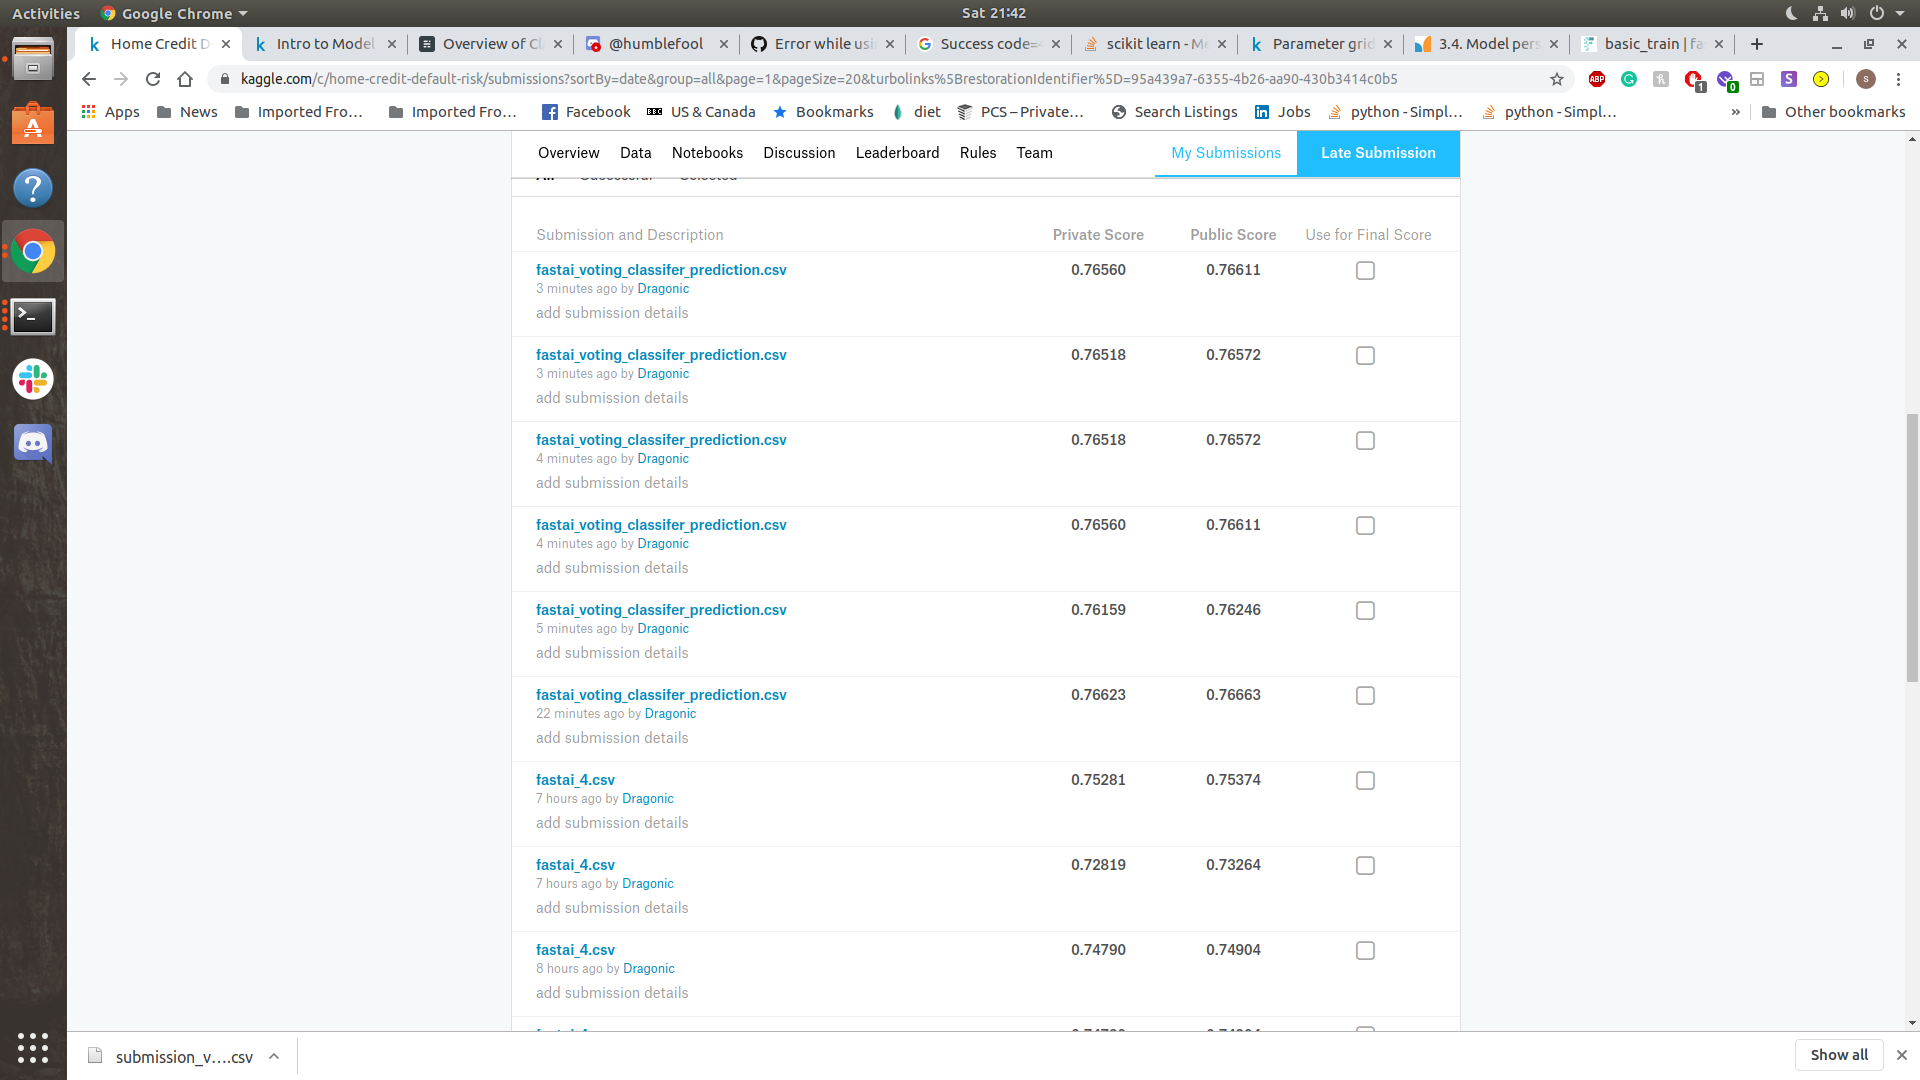

In [137]:
from IPython.display import Image
Image("comp_results/voting_fastai.png")

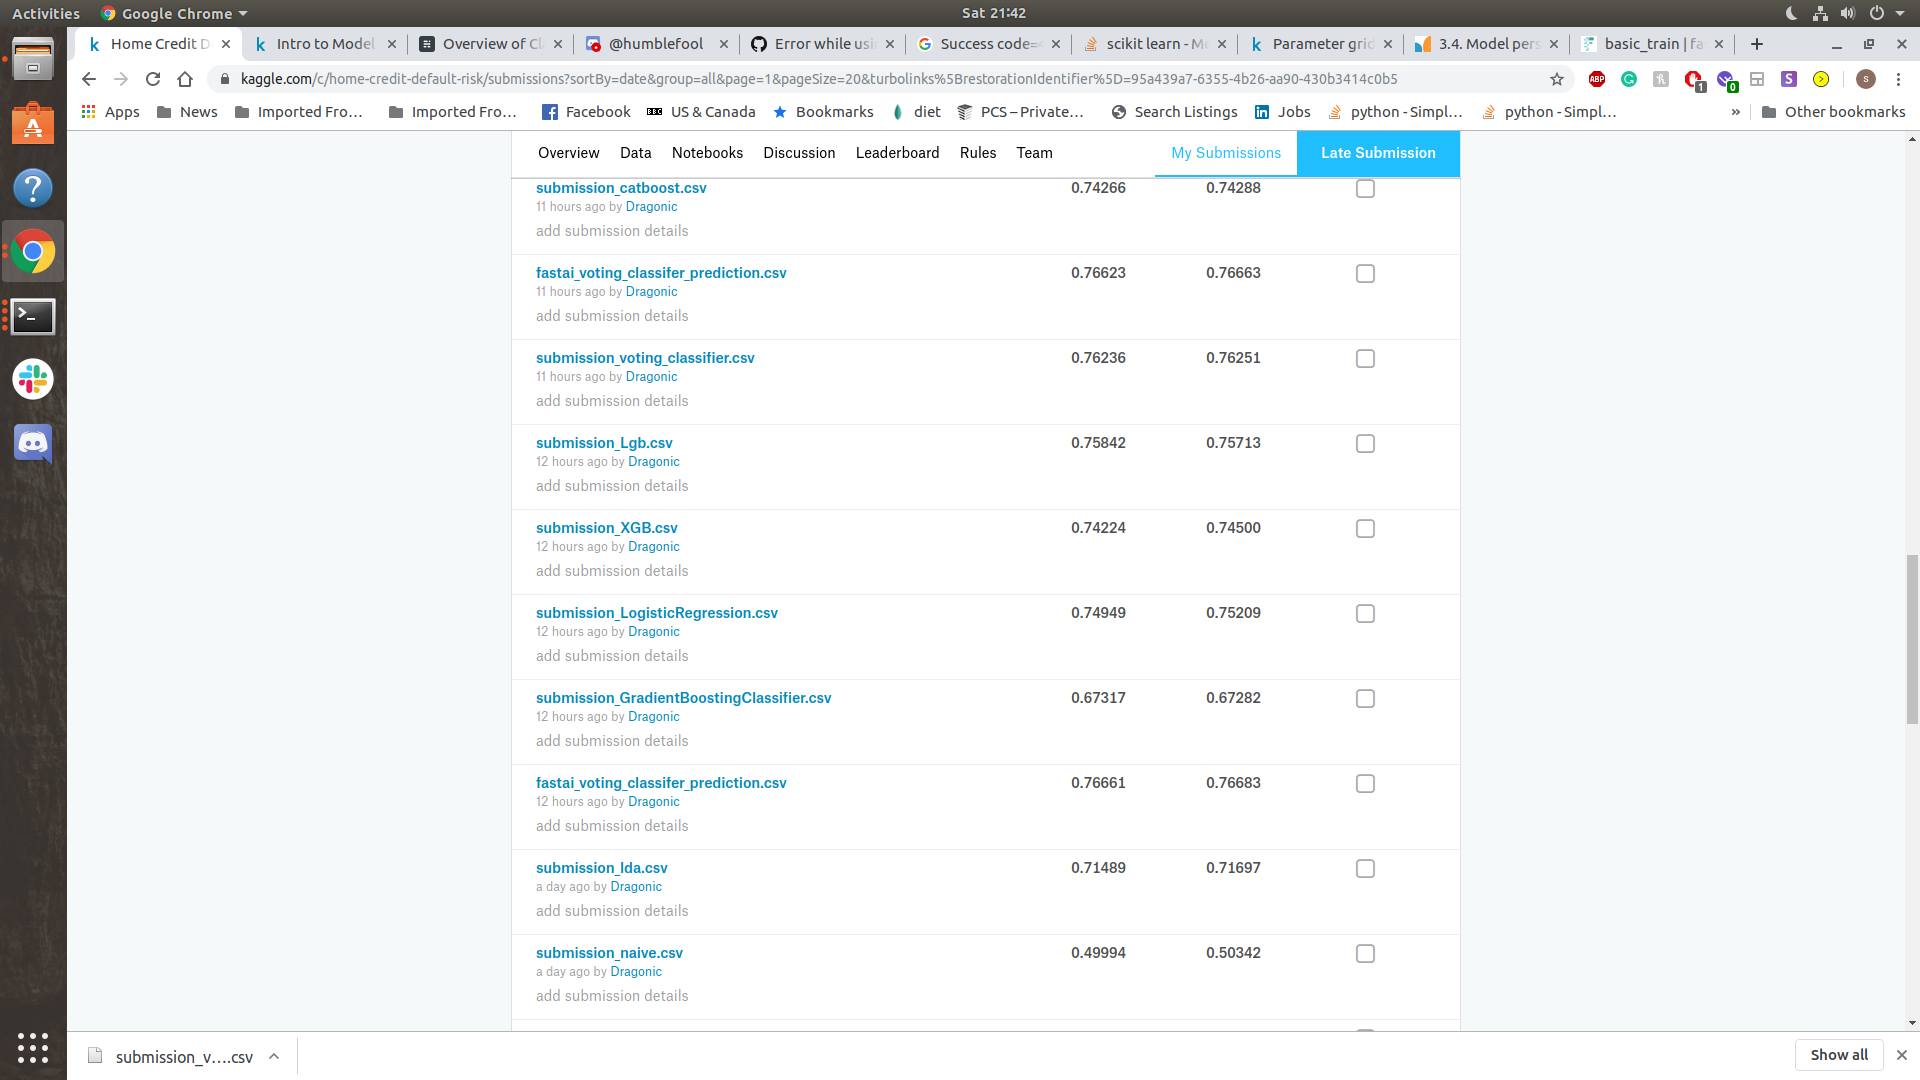

In [138]:
Image("comp_results/sklearn_models.png")